In [14]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

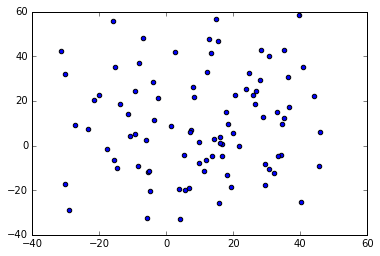

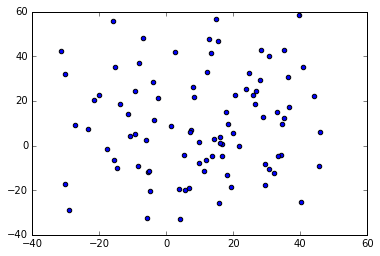

In [50]:
#Parameters

time = 0
timestep = 0.2
N = 100 #amount of particles
width = 10 #width of initial lattice
aR = 1 #average radius
r = aR*2.5 #lattice space
krep = 1 #repulsion coefficient
dzeta = 1
tau = dzeta / krep #characteristic timestep
chi = 1

lambdaFin = 0.3
Fin = lambdaFin * krep * aR
lambdaS = 1
Fself = lambdaS * krep * aR
Frepx = np.zeros(N)
Frepy = np.zeros(N)

lambdaTin = 3
Tin = lambdaTin * krep * chi / dzeta
lambdan = 0.03
Tnoise = (lambdan * 2 * krep * chi**2 / (dzeta * timestep))**0.5
lambdaa = 0.1
Talign = lambdaa * krep * chi / dzeta

#intialise lattice and particle properties

radius = np.random.normal(aR,aR/10,N) #radius matrix Nx1
normrad = radius/aR
area = np.pi * radius**2
initial_direction = [] #direction matrix Nx1
velocity = np.zeros(N)
angular_velocity = np.zeros(N)

pos = np.zeros((N,2)) #position matrix Nx2
x = []
y = []
ystep = np.linspace(0,N/width-1,N/width)*r

for i in ystep:
    x = np.append(x,np.linspace(0,width-1,width)*r)
    y = np.append(y,np.ones(width)*i)

for i in range(N):
        pos[i,0] = x[i] + np.random.uniform(-r/10,r/10)
        pos[i,1] = y[i] + np.random.uniform(-r/10,r/10)
        initial_direction = np.append(initial_direction,np.random.uniform(-np.pi/4,np.pi/4))

#plt.scatter(pos[:,0],pos[:,1],s=100*area,alpha=0.5)
#plt.show()

direction = initial_direction

fig = plt.figure()
ax = fig.add_subplot(111)

while time < 10:
    
    ax.cla()
    ax.scatter(pos[:,0], pos[:,1])
    ax.set_xlim((-40, 60))
    ax.set_ylim((-40, 60))
    display.clear_output(wait=True)
    display.display(fig)
    #time.sleep(0.05)
    
    #Determine neighbours
    boundary = np.zeros(N)
    thetaout = np.zeros(N)
    thetadiff = np.zeros(N)
    directiondiff = []

    for i in range(N):
        angles = []
        neighbours = []
        overlap = []
        anglediff = []

        for j in range(N):
            if i == j:
                continue
            d = ((pos[i,0]-pos[j,0])**2 + (pos[i,1]-pos[j,1])**2)**0.5
            if d < 2.7*aR:
                neighbours = np.append(neighbours,j)
                angles = np.append(angles,np.arctan2(pos[j,0]-pos[i,0], pos[j,1]-pos[i,1]))

                anglediff = np.append(anglediff,direction[i]-direction[j])

                if d < (radius[i] + radius[j]):
                    Aij = (radius[j]**2 * np.arccos((d**2 + radius[j]**2 - radius[i]**2)/(2*d*radius[j])) 
                        + radius[i]**2 * np.arccos((d**2 + radius[i]**2 - radius[j]**2)/(2*d*radius[i])) 
                        - 0.5*((-d+radius[i]+radius[j])*(d-radius[i]+radius[j])*(d+radius[i]-radius[j])*(d+radius[i]+radius[j]))**0.5)
                    overlap = np.append(overlap,Aij)
                else:
                    overlap = np.append(overlap,0)

        if len(neighbours) < 3:
            boundary = np.append(boundary,1.)
            for k in range(len(neighbours)):
                Frepx[i] += krep * overlap[k] * np.cos(angles[k])
                Frepy[i] += krep * overlap[k] * np.sin(angles[k])
        else:
            angles = np.sort(angles)
            for k in range(len(neighbours)):
                angle = (angles[(k+1)%(len(neighbours))] - angles[k])%(2*np.pi)
                if angle > np.pi:
                    boundary[i] = 1.
                    thetaout[i] = angle
                    thetadiff[i] = (angles[k] - ((2*np.pi - angle)/2)) - direction[i]

                Frepx[i] += krep * overlap[k] * np.cos(angles[k])
                Frepy[i] += krep * overlap[k] * np.sin(angles[k])

        directiondiff = np.append(directiondiff,np.sum(anglediff))

    #Force and torque

    for i in range(N):    
        Fx = np.sin(direction[i])*(Fself + boundary[i]*Fin*(thetaout[i]-np.pi)) - Frepx[i]
        Fy = np.cos(direction[i])*(Fself + boundary[i]*Fin*(thetaout[i]-np.pi)) - Frepy[i]
        T = Tin*thetadiff[i]*boundary[i] + Tnoise*np.random.uniform(-1,1) + Talign*directiondiff

        vx = Fx/(normrad[i] * dzeta)
        vy = Fy/(normrad[i] * dzeta)
        omega = T/(normrad[i]**2 * chi)

        pos[i,0] += vx * timestep
        pos[i,1] += vy * timestep
        direction += omega * timestep
        
        #print(vx)
    
    time += timestep
    #print(normrad)